
#Assignment Set 8

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU



In [9]:
#@title Manual Data Injection

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
 
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar/cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
 
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
 
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
 
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
 
    x_train = X_train.astype('float32')
    x_val = X_val.astype('float32')
    x_test = X_test.astype('float32')
    
    std = StandardScaler()

    x_train = std.fit_transform(x_train)
    x_val = std.transform(x_val)
    x_test = std.transform(x_test)
from sklearn.preprocessing import StandardScaler
    return x_train, y_train, x_val, y_val, x_test, y_test
 
# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()
 
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [12]:
x_train = x_train.reshape((-1,3,32,32))
x_train = np.transpose(x_train, (0,2, 3, 1))
x_train.shape

x_val = x_val.reshape((-1,3,32,32))
x_val = np.transpose(x_val, (0,2, 3, 1))
x_val.shape

x_test = x_test.reshape((-1,3,32,32))
x_test = np.transpose(x_test, (0,2, 3, 1))
x_test.shape

(10000, 32, 32, 3)

In [ ]:
#@title Multi Hidden Layer CNNs **Without** Output One-Hot Encoding
#@markdown Training convolutional neural networks with dropout and different optimization methods to compare the performance
mdl_pool = {}
for item in 'Adam','RMSprop','Adadelta','SGD':
    name = 'conv_clf_l2_'+item
    
    input = keras.Input(shape=(32,32,3))
    x = layers.Conv2D(32,3,activation="relu",kernel_regularizer=regularizers.l2(1e-4))(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(32,3,activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32,3,activation="relu",kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(32,3,activation="relu",kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128,activation="relu",kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(10,'softmax')(x)
    model = keras.Model(inputs=input, outputs=output, name=name)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
            optimizer=item,
            metrics=['accuracy'])
    epochs =  50#@param {type:"integer"}
    verbose =  2#@param {type:"number"}
    mdl_pool[name] = model.fit(x = x_train, y = y_train,
                            batch_size=64, epochs=epochs,
                            verbose=verbose,validation_data=(x_val,y_val),
                            validation_batch_size = 64).history
    mdl_pool[name]['eval'] = model.evaluate(x_test, y_test)

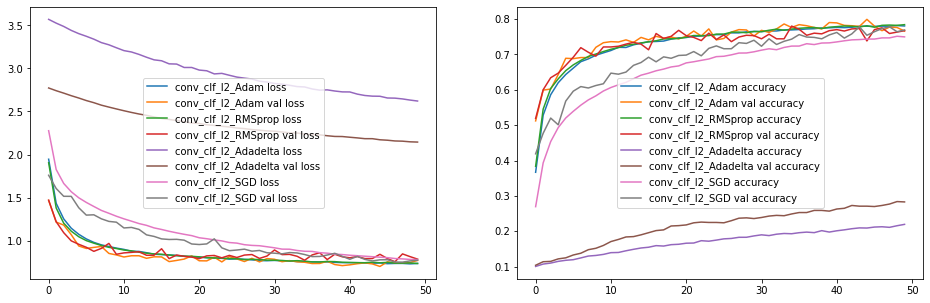

In [32]:
#@title Plotting Training History
plt.figure(figsize=(16,5))
plt.subplot(121)
for name,item in mdl_pool.items():
    plt.plot(item['loss'],label = name+' loss')
    plt.plot(item['val_loss'],label = name+' val loss')
plt.legend()

plt.subplot(122)
for name,item in mdl_pool.items():
    plt.plot(item['accuracy'],label = name +' accuracy')
    plt.plot(item['val_accuracy'],label = name+' val accuracy')
plt.legend()

In [33]:
#@title Evaluation of The Models Trained With Different Optimizers
for n,v in mdl_pool.items():
    print(n)
    print('\tloss',v['eval'][0])
    print('\taccuracy',v['eval'][1])

conv_clf_l2_Adam
	loss 0.7905704379081726
	accuracy 0.7684000134468079
conv_clf_l2_RMSprop
	loss 0.8081014752388
	accuracy 0.7669000029563904
conv_clf_l2_Adadelta
	loss 2.159144639968872
	accuracy 0.2743000090122223
conv_clf_l2_SGD
	loss 0.7987903952598572
	accuracy 0.7452999949455261
